# **Training a spiking neural network with surrogate gradients**

In this tutorial we will learn how to train (in a supervised fashion) a simple multi-layer spiking neural network (SNN) on a small synthetic dataset. Concretely, we want our network to classify a set of different random and sparse input spike trains into two categories (according to a random label assigned to each spike train). We won't worry about generalization now and only care about our ability to overfit these data. We will compare results in case we use a true gradient or a surrogate gradient for back-propagation.

Concretely, we will use the same SNN on the same task with: a) random weights, b) weights trained with the true gradient, c) weights trained with the surrogate gradient. This will help us to instill some basic understanding on surrogate gradient learning. For more details on this topic, please see:

> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks. IEEE Signal Process Mag 36, 51–63.
> https://ieeexplore.ieee.org/document/8891809 and https://arxiv.org/abs/1901.09948

In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm

Use GPU if possible!

*Note: for small models like this one there will be no speed-up of the training process.*

In [2]:
dtype = torch.float
if torch.cuda.is_available():  # Print additional info when using cuda
    device = torch.device('cuda:0')
    current_dev = torch.cuda.current_device()
    cap_dev = torch.cuda.get_device_capability()
    print('\nRunning on GPU', torch.cuda.get_device_name(device),
          '(compute capability {}.{})'.format(cap_dev[0], cap_dev[1]),
          'number', current_dev + 1, 'of', torch.cuda.device_count())
    print('Total memory:     ', round(torch.cuda.get_device_properties(current_dev).total_memory / 1024 ** 2, 1), 'MB')
    print('Allocated memory: ', round(torch.cuda.memory_allocated(current_dev) / 1024 ** 2, 1), 'MB')
    print('Cached memory:    ', round(torch.cuda.memory_reserved(current_dev) / 1024 ** 2, 1), 'MB\n')
else:
    device = torch.device('cpu')
    print('\nRunning on CPU.\n')


Running on GPU GeForce RTX 2070 with Max-Q Design (compute capability 7.5) number 1 of 1
Total memory:      7982.3 MB
Allocated memory:  0.0 MB
Cached memory:     0.0 MB



Set a random seed for all stochastic computations.

In [3]:
seed = 12

## Some theory first

### 1. Introduction 

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks that solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success that has raised both the bar and the question of how well this progress would translate to spiking neural networks.

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This development begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to these questions cannot be given at the moment, it seems that we can learn a lot.

In this tutorial, we use insights and tools from machine learning to build, step-by-step, a spiking neural network. Explicitly, we set out with the goal of building networks that solve (simple) real-world problems. To that end, we focus on classification problems and use supervised learning in conjunction with the aforementioned back-propagation algorithm. To do this, we have to overcome a vanishing gradient problem caused by the binary nature of the spikes themselves.

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to a discrete-time recurrent neural network (RNN). We will use this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in PyTorch.

### 2. Mapping LIF neurons to RNN dynamics

The de-facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:

$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}(t)-U_\mathrm{rest}) + RI_i^{(l)}(t) + S_i^{(l)}(t)(U_{reset}-\vartheta)$$

where $U_i^{(l)}$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. The last term takes into account the fact that, whenever a neuron emits a spike ($S_i(t)$ is the spike train), its membrane potential must be instantaneously decreased (by the amount $\vartheta - U_{reset}$): i.e., after having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{reset}$. Typically the reset potential is set equal to the resting potential. We write the spike train of a neuron (i.e. the sum of all spikes $C_i^l$ emitted by neuron $i$ in layer $l$) as:

$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_i^k)$$

where $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of the neuron.

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write:

$$\frac{\mathrm{d}I_i^{(l)}}{\mathrm{d}t}= -\frac{I_i^{(l)}(t)}{\tau_\mathrm{syn}} + \sum_{j \in l-1} W_{ij} S_j^{(l-1)}(t) + \sum_{j \in l} V_{ij} S_j^{(l)}(t)$$

where we have introduced the synaptic weight matrices $W_{ij}$ (feed-forward), $V_{ij}$ (recurrent), and the synaptic decay time constant $\tau_\mathrm{syn}$.

To link to RNNs apparent, we will now express the above equations in discrete time. In the interest of brevity we switch to natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice, and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike, we start by noting that we can set $$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$ where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by:

$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_{j \in l-1} W_{ij} S_j^{(l-1)}(t) +\sum_{j \in l} V_{ij} S_j^{(l)}(t)$$

with the constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as:

$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$

with the output $S_i(t) = \Theta(U_i(t)-1)$ and the constant $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.



These equations can be summarized succinctly as the computational graph of an RNN with a specific connectivity structure.

<img src="https://images.deepai.org/converted-papers/1901.09948/x3.png" width="250">

Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($S_i^{(0)}$). These inputs sequentially influence the synaptic currents $I_i^{(1)}$, membrane potentials the $U_i^{(1)}$, and finally the spiking output $S_i^{(1)}$.  Moreover, dynamic quantities have direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity.

The computational graph illustrates a concept which is known as unrolling in time, which emphasizes the duality between a deep neural network and a recurrent neural network, which is nothing more but a deep network in time (with tied weights). Due to this fact, we can train RNNs using the back-propagation of error through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now, let us start by implementing the above dynamics in a three-layer spiking neural network in PyTorch.

To summarize, the LIF neuron dynamics can be written in discrete time as:

$$
\begin{align*}
    U_i[n+1] & = \beta U_i[n] + I_i[n] - S_i[n] \\
    I_i[n+1] & = \alpha I_i[n] + \sum_{j \in l-1} W_{ij} S_j[n] + \sum_{k \in l} V_{ik} S_k[n]
\end{align*}
$$

with the output spikes $S_i[n] = \Theta(U_i[n]-\vartheta)$ governed by the spiking nonlinearity $\Theta$.

## Define all main parameters

**Initialize network parameters**: number of neurons in each layer.

We will use a simple feedforward multilayer network model with a single hidden layer. For simplicity, we will not use recurrent connections $V$ for now, keeping in mind that they can be added later should the need arise.

For the sake of argument, we set the numbers for the input, hidden and output neurons as follows:

In [4]:
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

Set a weight scale for weights initialization (if you with, otherwise leave it to None). Be carefull if you change this value: make sure that the given weight scale will give us some spikes to begin with.

In [5]:
weight_scale = None

**Initialize simulation parameters**: time of the simulation.

As we have seen above, we are technically simulating an RNN. Thus we have to simulate our neurons for a certain number of timesteps. We will use 1ms time step, and we want to simulate our network for say 200 timesteps.

In [6]:
time_step = 1e-3
nb_steps  = 200

**Initialize training parameters**: number of epochs, learning rate and batch size.

In [7]:
nb_epochs = 1000
lr = 2e-3

To take advantage of parallelism, we will set up our code to work on batches of data like this is usually done for neural networks that are trained in a supervised manner.
To that end, we specify a batch size here.

In [8]:
batch_size = 256

**Initialize LIF-neuron parameters**: synaptic and membrane time constants.

In [9]:
tau_mem = 10e-3
tau_syn = 5e-3

With these basic design choices made, we can now start building the actual network. Here we will be using PyTorch, but you will be able to reproduce these results in most common machine learning libraries.

## Create a simple synthetic random dataset

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data, we fill a tensor of (batch_size, nb_steps, nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [10]:
freq = 5  # Hz
prob = freq*time_step
np.random.seed(seed)
mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask < prob] = 1.  # activity of input layer: (batch_size, nb_steps, nb_inputs)

If we plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

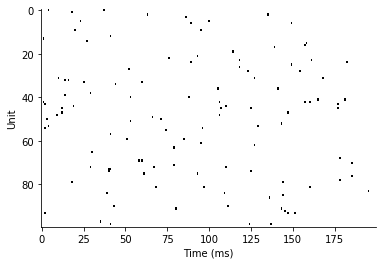

In [11]:
data_id = 0
plt.figure(figsize=(6, 4))
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [12]:
y_data = torch.tensor(1 * (np.random.rand(batch_size)<0.5), device=device)

Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

## Setup of the spiking network model

In order to compute the spikes in the SNN we must first define its spiking nonlinearity function. Here we define 2 distinct spiking nonlinearities: one used for training the network with the True Gradient and one for the Surrogate Gradient.

#### The spiking nonlinearity

In discrete-time, as explained earlier, we can formulate our spiking nonlinearity as a Heaviside step function. This will give us the True Gradient. One way of implementing a Heaviside function is the following:

In [13]:
def TrueGradSpike(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

As we will see, by training the spiking network with the true gradient, the hidden layer units will not participate much to the learning process. The underlying reason is that the partial derivative of the step function we use has a vanishing derivative everywhere (except at zero where it becomes infinite).

Most conventional neural networks avoid this problem by choosing a nonlinearity with non-zero partial derivative. For instance, sigmoidal or tanh units were standard during the beginnings of neural networks research. Today, ReLUs are more common. Importantly, all these activation functions have substantial non-zero support, which allows gradients to flow (to a greater or lesser extent).

What can we do if we want to stick to our binary nonlinearity? There have been several approaches to tackle this problem. Here we use one such strategy which has been applied successfully to spiking neural networks: we use a surrogate gradient approach.

The idea behind a surrogate gradient is dead simple. Instead of changing the nonlinearity itself, we only change the gradient. Thus we use a different "surrogate" gradient to optimize parameters that would otherwise have a vanishing gradient.

<img src="https://www.researchgate.net/publication/348757643/figure/fig1/AS:984073468137472@1611632806035/Surrogate-gradient-for-activation-function-Different-Sigmoid-functions-can-be-a-suitable.png" width="650">

Specifically, we use the partial derivative of a function which to some extent approximates the stepfunction $\Theta(x)$.
In what follows, chiefly, we will use (up to rescaling) the partial derivative of a fast sigmoid function $\sigma(x)$. 
While $\Theta$ is invariant to multiplicative rescaling, $\sigma$ isn't. Thus we have to introduce a scale parameter.

In [14]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0  # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad

#### The whole network

Now is the time to build the infrastructure for simulating and training our spiking neural network (in discrete time). The SNN we use is made of an input layer (the data), a hidden layer and a readout layer.

 - First of all we define all main variables.

 - We then set-up our weight matrices, which connect the input and the hidden layer, as well as the matrix connecting the hidden layer with the output layer. Moreover, we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections. Moreover, for the sake of simplicity, we ignore Dale's law in this tutorial. Thus weights can be either excitatory or inhibitory. This choice is prevalent in artificial neural networks.
 
 - We then compute the activity of the hidden layer. We thus initialize the synaptic currents and membrane potentials of such layer at zero. Next, we need to implement a loop that simulates our neuron models over time. We multiply all input spikes with the input weight matrix in order to get the total weighted input of the hidden layer $h_1$. We have to do this for each time step in each input example in the batch. These "weighted" input spikes will now feed into our synaptic variable and, ultimately, the membrane potential of the hidden layer. We will record the membrane potentials and output spikes of all trials and all neurons.
 
 - To use our network as a classifier, we need to have a readout layer on whose output we can define a cost function (analog signal). There are several possibilities for doing this. For instance, we could count output layer spikes, or we could directly define an objective function on the membrane potential of the output neurons. Here we will follow the latter approach, but keep in mind that there are many other possibilities of defining an output layer and respective cost functions on them. Here we build the output layer as a population of non-spiking leaky-integrator neurons. Therefore, similar steps as for the hidden layer are repeated for computing the activity of the readout layer (in this case $h_2$ is the product of the output weights with the spiking activity of the hidden layer) but no output spikes are computed.
 
 - Since we prevent the output neurons from spiking, in order to compare them with the target labels we must define some activation function on their output voltage traces. Specifically, we use the maximum voltage over time of each output unit $$\hat U^\mathrm{out}_i=\max_t U^\mathrm{out}_i(t)$$ and then use this vector as input for either an argmax to compute the classification accuracy or as input for a standard softmax function in conjunction with a negative log-likelihood loss for optimizing the weights in the network.
  
 - To trigger a spike in the hidden layer (no spikes in the readout layer), we need to define a spiking nonlinearity function (together with a threshold). We will alter this definition to train the network with the true gradient or the surrogate gradient approaches.
 
 - To train our network (learn/adjust all the weights with the aim to decrease the specified objective), we will use the vanilla method, i.e. gradient descent. Machine learning libraries like Tensorflow and PyTorch make implementing gradient descent a breeze. We will perform gradient descent both on the correct gradient and on the surrogate gradient to see the differences in performance.

In [15]:
class SNN:
    def __init__(self,
                 time_step=1e-3, nb_steps=200, batch_size=256,
                 nb_inputs=100, nb_hidden=4, nb_outputs=2,
                 tau_mem=10e-3, tau_syn=5e-3, weight_scale=None,
                 truegrad=False, seed=None,
                 use_gpu=True, dtype=None, device=None, verbose=True):
        # Initialize torch parameters
        self.verbose = verbose
        self._dtype = torch.float if dtype is None else dtype
        self._device = (self._init_gpu() if use_gpu else torch.device('cpu')) if device is None else device
        self._seed = seed
        if self._seed is not None:
            torch.manual_seed(self._seed)
        # Initialize simulation parameters
        self._dt = time_step
        self.nb_ts = nb_steps
        # Initialize network parameters
        self.nb_in = nb_inputs
        self.nb_hid = nb_hidden
        self.nb_out = nb_outputs
        self.batch_sz = batch_size
        # Initialize LIF-neuron parameters
        self._tau_mem = tau_mem
        self._tau_syn = tau_syn
        self._alpha = float(np.exp(-self._dt / self._tau_syn))
        self._beta = float(np.exp(-self._dt / self._tau_mem))
        # Define activation function
        self._truegrad = truegrad
        self._spike_fn = TrueGradSpike if self._truegrad else SurrGradSpike.apply
        # Initialize weights
        self.weight_scale = 7 * (1.0 - self._beta) if weight_scale is None \
            else weight_scale  # make sure the given weight scale will give us some spikes to begin with
        self._w1, self._w2 = self.init_weights()

    @property
    def truegrad(self):
        return self._truegrad

    @truegrad.setter
    def truegrad(self, new_value):
        self._truegrad = new_value
        self._spike_fn = TrueGradSpike if self._truegrad else SurrGradSpike.apply

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, new_value):
        self._seed = new_value
        if self._seed is not None:
            torch.manual_seed(self._seed)

    @property
    def tau_mem(self):
        return self._tau_mem

    @tau_mem.setter
    def tau_mem(self, new_value):
        self._tau_mem = new_value
        self._beta = float(np.exp(-self._dt / self._tau_mem))

    @property
    def tau_syn(self):
        return self._tau_syn

    @tau_syn.setter
    def tau_syn(self, new_value):
        self._tau_syn = new_value
        self._alpha = float(np.exp(-self._dt / self._tau_syn))

    @property
    def time_step(self):
        return self._dt

    @time_step.setter
    def time_step(self, new_value):
        self._dt = new_value
        self._alpha = float(np.exp(-self._dt / self._tau_syn))
        self._beta = float(np.exp(-self._dt / self._tau_mem))

    @property
    def weights(self):
        return [np.copy(self._w1.cpu().detach().numpy()),
                np.copy(self._w2.cpu().detach().numpy())]

    def _init_gpu(self):
        # Use GPU if possible!
        if torch.cuda.is_available():  # Print additional info when using cuda
            dev = torch.device('cuda:0')
            curr_dev = torch.cuda.current_device()
            dev_cap = torch.cuda.get_device_capability()
            if self.verbose:
                print('\nRunning on GPU', torch.cuda.get_device_name(dev),
                      '(compute capability {}.{})'.format(dev_cap[0], dev_cap[1]),
                      'number', curr_dev + 1, 'of', torch.cuda.device_count())
                print('Total memory:     ',
                      round(torch.cuda.get_device_properties(curr_dev).total_memory / 1024 ** 2, 1), 'MB')
                print('Allocated memory: ', round(torch.cuda.memory_allocated(curr_dev) / 1024 ** 2, 1), 'MB')
                print('Cached memory:    ', round(torch.cuda.memory_reserved(curr_dev) / 1024 ** 2, 1), 'MB\n')
        else:
            dev = torch.device('cpu')
            if self.verbose:
                print('\nRunning on CPU.\n')
        return dev

    def init_weights(self):
        w_1 = torch.empty((self.nb_in, self.nb_hid), device=self._device, dtype=self._dtype, requires_grad=True)
        torch.nn.init.normal_(w_1, mean=0.0, std=self.weight_scale / np.sqrt(self.nb_in))
        w_2 = torch.empty((self.nb_hid, self.nb_out), device=self._device, dtype=self._dtype, requires_grad=True)
        torch.nn.init.normal_(w_2, mean=0.0, std=self.weight_scale / np.sqrt(self.nb_hid))
        return w_1, w_2

    def run(self, X):
        # Compute HIDDEN layer activity
        h1 = torch.einsum("abc,cd->abd",
                          (X, self._w1))  # weighted input to hidden layer: (batch_size, nb_steps, nb_hidden)
        syn = torch.zeros((self.batch_sz, self.nb_hid), device=self._device, dtype=self._dtype)
        mem = torch.zeros((self.batch_sz, self.nb_hid), device=self._device, dtype=self._dtype)
        hidden_mem, hidden_spk = [], []
        for t in range(self.nb_ts):
            # Compute spikes
            mthr = mem - 1.0
            spk = self._spike_fn(mthr)
            rst = spk.detach()  # We do not want to backprop through the reset

            # Compute internal variables
            new_syn = self._alpha * syn + h1[:, t]
            new_mem = (self._beta * mem + syn) * (1.0 - rst)

            # Record some variables
            hidden_mem.append(mem)
            hidden_spk.append(spk)

            # Update internal variables
            mem = new_mem
            syn = new_syn
        hidden_mem = torch.stack(hidden_mem, dim=1)
        hidden_spk = torch.stack(hidden_spk, dim=1)

        # Compute READOUT layer activity
        h2 = torch.einsum("abc,cd->abd",
                          (hidden_spk, self._w2))  # weighted input to the readout: (batch_size, nb_steps, nb_outputs)
        syn = torch.zeros((self.batch_sz, self.nb_out), device=self._device, dtype=self._dtype)
        mem = torch.zeros((self.batch_sz, self.nb_out), device=self._device, dtype=self._dtype)
        readout_mem = [mem]
        for t in range(self.nb_ts):
            # Compute internal variables
            new_syn = self._alpha * syn + h2[:, t]
            new_mem = self._beta * mem + syn

            # Update internal variables
            syn = new_syn
            mem = new_mem

            # Record some variables
            readout_mem.append(mem)
        readout_mem = torch.stack(readout_mem, dim=1)

        return readout_mem, [hidden_mem, hidden_spk]

    def train(self, X, y, epochs=1000, lr=2e-3, refresh_pbar=True):
        if self.verbose:
            t0 = time.time()
            print('\nTraining the SNN with {} gradient...'.format('True' if self._truegrad else 'Surrogate'))

        params = [self._w1, self._w2]  # parameters to optimize
        optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))  # The optimizer we are going to use

        log_softmax_fn = nn.LogSoftmax(dim=1)  # The log softmax function across output units
        loss_fn = nn.NLLLoss()  # The negative log likelihood loss function

        # The optimization loop
        loss_hist = []
        pbar = tqdm(total=epochs, desc='Epoch 0 (loss=N.D.)', file=sys.stdout, leave=True)
        for e in range(epochs):
            # Run the network and get output
            output, _ = self.run(X)

            # Compute the loss
            m, _ = torch.max(output, 1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y)

            # Update the weights
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss value
            loss_hist.append(loss_val.item())

            # Update the progress bar
            pbar.update(1)
            pbar.set_description("Epoch %i (loss=%.3f)" % (e + 1, loss_hist[-1]), refresh=refresh_pbar)
        pbar.close()
        if self.verbose:
            print('It took %.1f seconds to train the SNN.' % (time.time() - t0))

        return loss_hist

    def predict(self, X):
        return self.run(X)

    def evaluate_accuracy(self, X, y):
        """Dirty little helper function to compute classification accuracy."""
        y_pred, _ = self.predict(X)
        m, _ = torch.max(y_pred, 1)  # max over time
        _, am = torch.max(m, 1)  # argmax over output units
        acc = np.mean((y == am).detach().cpu().numpy())  # compare to labels
        if self.verbose:
            print("Accuracy is %.3f" % acc)
        return acc

    def plot_voltage_traces(self, mem, spk=None, dim=(3, 5), spike_height=5, title=None, show=True):
        fig = plt.figure(figsize=(12, 8))
        if not title:
            method = {True: 'trained with True Gradient', False: 'trained with Surrogate Gradient'}.get(self._truegrad)
            title = 'Membrane Voltages of the SNN\n' + method
        fig.suptitle(title)
        gs = GridSpec(*dim, figure=fig)
        if spk is not None:
            dat = 1.0 * mem
            dat[spk > 0.0] = spike_height
            dat = dat.detach().cpu().numpy()
        else:
            dat = mem.detach().cpu().numpy()
        for i in range(np.prod(dim)):
            if i == 0:
                a0 = ax = plt.subplot(gs[i])
            else:
                ax = plt.subplot(gs[i], sharey=a0)
            ax.plot(dat[i])
            ax.axis("off")
        if show:
            plt.show()

    def plot_loss(self, loss, title=None):
        fig = plt.figure(figsize=(5, 5))
        if not title:
            method = {True: 'trained with True Gradient', False: 'trained with Surrogate Gradient'}.get(self._truegrad)
            title = 'Loss of the SNN\n' + method
        fig.suptitle(title)
        plt.plot(loss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        sns.despine()
        plt.show()

## a) Dummy SNN (random weights, no training)

Here we only run the network on the given data without any training.
We expect the accuracy to be somewhere around 50% (corresponding to the chance level of our synthetic task (targets are binary).

Note that we chose to use the Heaviside step function as a spiking nonlinearity in the hidden layer (thus the truegrad variable is set to True), but similar results can be obtained with that proposed in the surrogate gradient approach (defined in SurrGradSpike).

In [16]:
snn_notrain = SNN(time_step=time_step, nb_steps=nb_steps,
                  nb_inputs=nb_inputs, nb_hidden=nb_hidden, nb_outputs=nb_outputs,
                  batch_size=batch_size, tau_mem=tau_mem, tau_syn=tau_syn, weight_scale=weight_scale,
                  truegrad=True,
                  device=device, dtype=dtype, seed=seed, verbose=True)

In [17]:
# Note that we just evaluate the performance (no call to the training method)
print('\nNot trained SNN.')
acc_notrain = snn_notrain.evaluate_accuracy(x_data, y_data)


Not trained SNN.
Accuracy is 0.488


Let's store the weights of this SNN. Note that these weights are purely random since no training was performed.

In [18]:
w1_nt, w2_nt = snn_notrain.weights

Let'n now give a look at the membrane traces in both the hidden and the readout layers.

In [19]:
y_hat_notrain, other_vars_notrain = snn_notrain.predict(x_data)

Look at the membrane voltages in the **hidden** layer first.

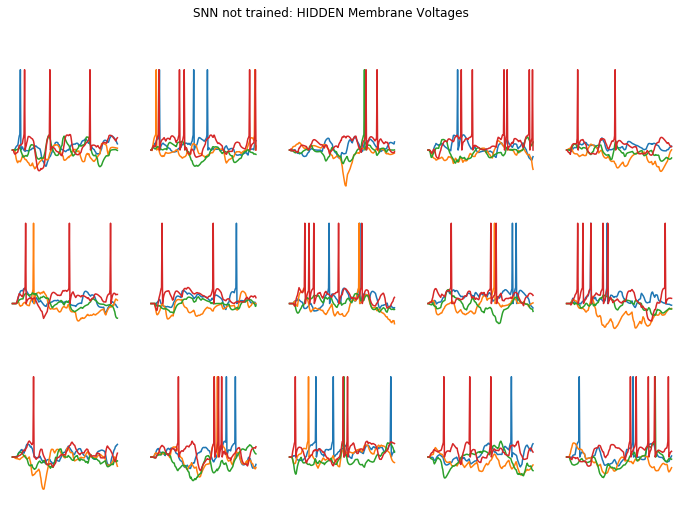

In [20]:
snn_notrain.plot_voltage_traces(*other_vars_notrain,
                                title='SNN not trained: HIDDEN Membrane Voltages')

And then at the membrane voltages in the **readout** layer.

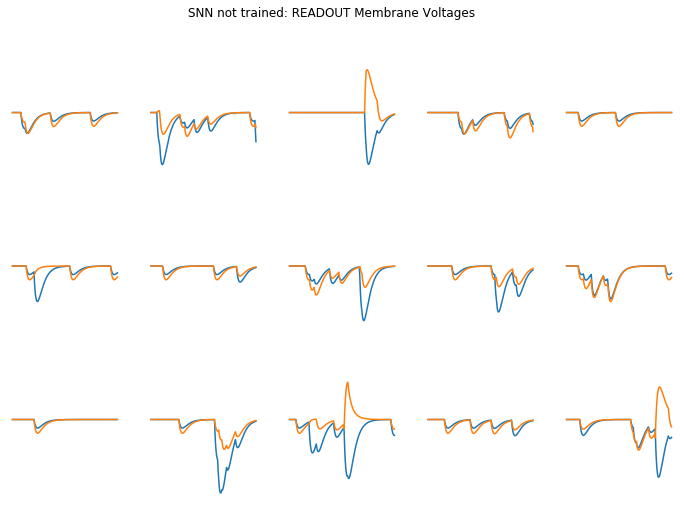

In [21]:
snn_notrain.plot_voltage_traces(y_hat_notrain,
                                title='SNN not trained: READOUT Membrane Voltages')

As you can see, our random initialization gives us some sporadic spiking in the hidden layer.

## b) SNN trained with the True Gradient

Here we train the network on the given dataset with backpropagation of the **True Gradient** (note that we have set the truegrad variable to True).
We expect the SNN to classify the input spike trains slightly better than the dummy SNN.

In [22]:
snn_truegrad = SNN(time_step=time_step, nb_steps=nb_steps,
                   nb_inputs=nb_inputs, nb_hidden=nb_hidden, nb_outputs=nb_outputs,
                   batch_size=batch_size, tau_mem=tau_mem, tau_syn=tau_syn, weight_scale=weight_scale,
                   truegrad=True,
                   device=device, dtype=dtype, seed=seed, verbose=True)

In [23]:
# Note that we call the training method
loss_truegrad = snn_truegrad.train(x_data, y_data, epochs=nb_epochs, lr=lr)
# And then evaluate network performance
acc_truegrad = snn_truegrad.evaluate_accuracy(x_data, y_data)


Training the SNN with True gradient...
Epoch 1000 (loss=0.693): 100%|██████████| 1000/1000 [00:57<00:00, 17.25it/s]
It took 58.0 seconds to train the SNN.
Accuracy is 0.520


Let's store the weights of this SNN. Note that these weights are obtained by training the network with the true gradient (before training, such weights will be identical to those of the dummy network since we have set the same random seed for their initialization).

In [24]:
w1_tg, w2_tg = snn_truegrad.weights

Let'n now give a look at the membrane traces in both the hidden and the readout layers.

In [25]:
y_hat_truegrad, other_vars_truegrad = snn_truegrad.predict(x_data)

Look at the membrane voltages in the **hidden** layer first.

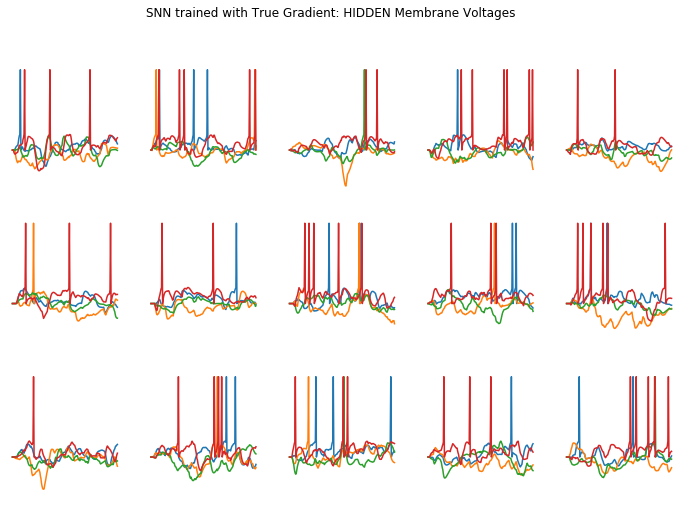

In [26]:
snn_truegrad.plot_voltage_traces(*other_vars_truegrad,
                                 title='SNN trained with True Gradient: HIDDEN Membrane Voltages')

And then at the membrane voltages in the **readout** layer.

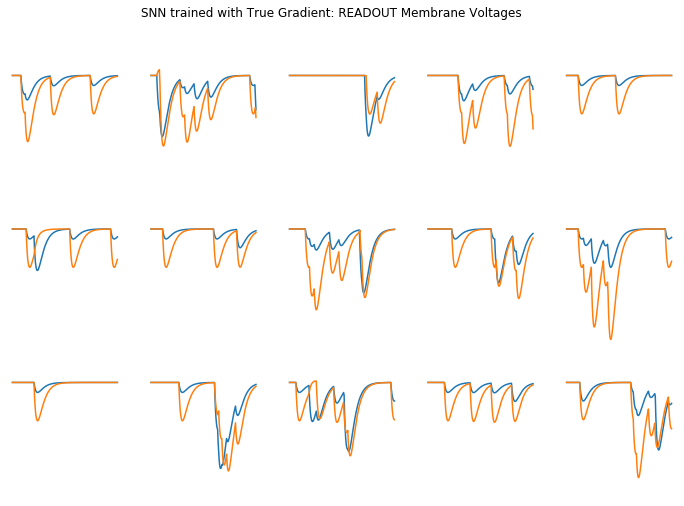

In [27]:
snn_truegrad.plot_voltage_traces(y_hat_truegrad,
                                 title='SNN trained with True Gradient: READOUT Membrane Voltages')

Notice that the output voltages in the hidden layer are the same as those plotted before, while those in the readout layer have changed. Thus the learning procedure with the true gradient did not adjust the weights in the hidden layer (input-hidden connections), while it had an effect on those in the readout (hidden-readout).

The underlying reason is that such gradient vanishes while moving backwards towards inner layers of the network. This is because the Heaviside nonlinearity of the hidden units have zero derivatives everywhere except at threshold crossings, where they become infinite. In practice that means that weight updates in the hidden layer vanish and the weights remain unmodified (we saw this from the plots of the activations in the hidden layer, since they have not changed from before, and we will also see it by plotting the weights later on). Thus no learning happens in the hidden layer.

Let's now plot the loss as a function of the training epochs.

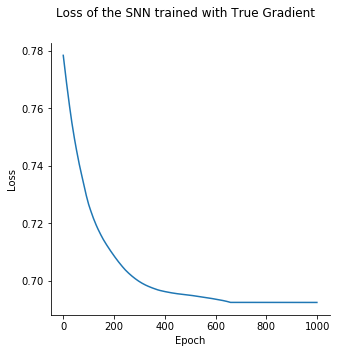

In [28]:
snn_truegrad.plot_loss(loss_truegrad,
                       title='Loss of the SNN trained with True Gradient')

We can appreciate the fact that loss slightly decreases over iterations and converges towards a steady state. The classification accuracy, however, does not improve dramatically throughout the optimization (look at the range of loss values). This is due to the vanishing gradient. The reason why the loss decreases during optimization, despite no learning occurres in the hidden layer, is that the output layer weights could still change and allow for some improvement (even if it is very little).

To improve performance, we need to get the hidden layer units to take part in learning. To achieve this, we will train the SNN with the surrogate gradient in the next section.

## c) SNN trained with the Surrogate Gradient

In [29]:
snn_surrgrad = SNN(time_step=time_step, nb_steps=nb_steps,
                   nb_inputs=nb_inputs, nb_hidden=nb_hidden, nb_outputs=nb_outputs,
                   batch_size=batch_size, tau_mem=tau_mem, tau_syn=tau_syn, weight_scale=weight_scale,
                   truegrad=False,
                   device=device, dtype=dtype, seed=seed, verbose=True)

Here we train the network on the given dataset with backpropagation of the **Surrogate Gradient** (note that we have set the truegrad variable to False).
We expect to further improve classifation performance of the SNN on the input spike trains.

In [30]:
# Note that we call the training method
loss_surrgrad = snn_surrgrad.train(x_data, y_data, epochs=nb_epochs, lr=lr)
# And then evaluate network performance
acc_surrgrad = snn_surrgrad.evaluate_accuracy(x_data, y_data)


Training the SNN with Surrogate gradient...
Epoch 1000 (loss=0.375): 100%|██████████| 1000/1000 [01:34<00:00, 10.61it/s]
It took 94.2 seconds to train the SNN.
Accuracy is 0.977


Let's store the weights of this SNN. Note that these weights are obtained by training the network with the surrogate gradient (before training, such weights will be identical to those of the dummy network since we have set the same random seed for their initialization).

In [31]:
w1_sg, w2_sg = snn_surrgrad.weights

Let'n now give a look at the membrane traces in both the hidden and the readout layers.

In [32]:
y_hat_surrgrad, other_vars_surrgrad = snn_surrgrad.predict(x_data)

Look at the membrane voltages in the **hidden** layer first.

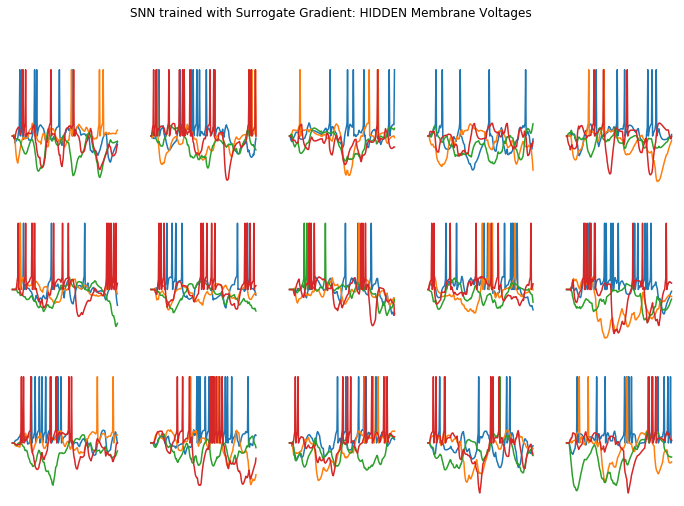

In [33]:
snn_surrgrad.plot_voltage_traces(*other_vars_surrgrad,
                                 title='SNN trained with Surrogate Gradient: HIDDEN Membrane Voltages')

And then at the membrane voltages in the **readout** layer.

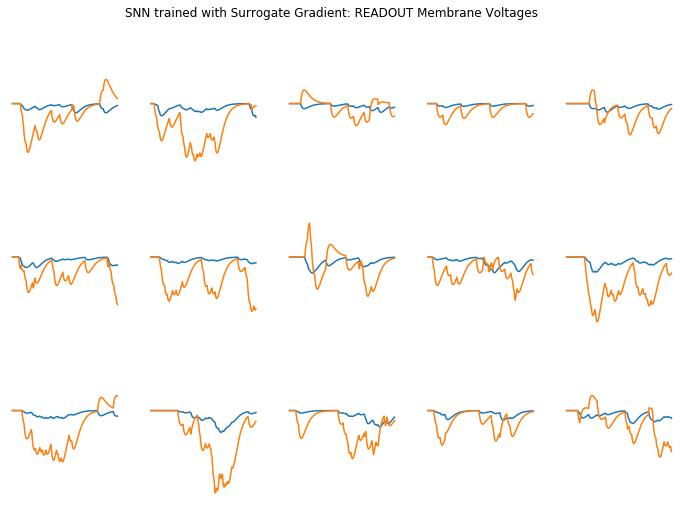

In [34]:
snn_surrgrad.plot_voltage_traces(y_hat_surrgrad,
                                 title='SNN trained with Surrogate Gradient: READOUT Membrane Voltages')

Notice that the output voltages in the hidden layer are different from before, as well as for the readout layer. Thus the learning procedure with the surrogate gradient had an effect on both the hidden and the readout layers (the surrogate gradient could be back-propagated in the network without vanishing).

Let's now plot the loss as a function of the training epochs and compare it to the previous one. We can notice that the loss significantly decreases with optimization in this case (and final accuracy markedly increases).

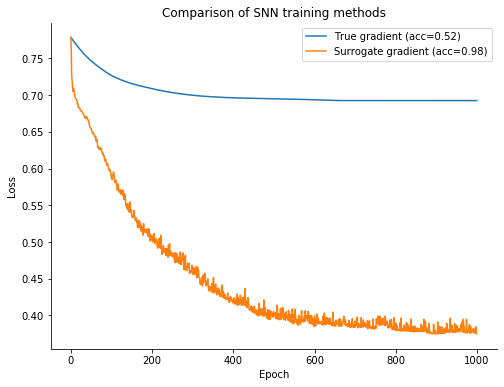

In [35]:
plt.figure(figsize=(8, 6))
plt.title('Comparison of SNN training methods')
plt.plot(loss_truegrad, label="True gradient (acc=%.2f)" % acc_truegrad)
plt.plot(loss_surrgrad, label="Surrogate gradient (acc=%.2f)" % acc_surrgrad)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()
plt.show()

As a final proof that the true gradient is markedly affected by the vanishing effect during back-propagation (while such effect is lower in case of a surrogate gradient approach), we plots the weights in both hidden and readout layers in all 3 situations (no training, training with true gradient and training with surrogate gradient). Notice that, in the hidden layer, weights after training with the True Gradient are the same as those before training and different from those optimized with the Surrogate Gradient approach.

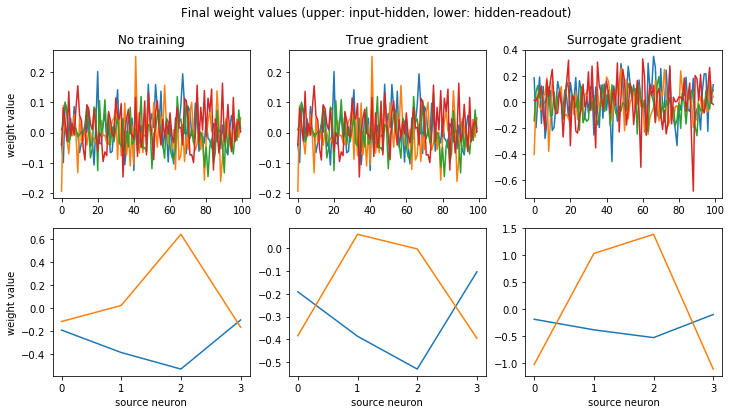

In [36]:
plt.figure(figsize=(12, 6))
plt.suptitle('Final weight values (upper: input-hidden, lower: hidden-readout)')
plt.subplot(231)
plt.title('No training')
plt.ylabel('weight value')
plt.plot(w1_nt)
plt.subplot(232)
plt.title('True gradient')
plt.plot(w1_tg)
plt.subplot(233)
plt.title('Surrogate gradient')
plt.plot(w1_sg)
plt.subplot(234)
plt.ylabel('weight value')
plt.xlabel('source neuron')
plt.plot(w2_nt)
plt.subplot(235)
plt.xlabel('source neuron')
plt.plot(w2_tg)
plt.subplot(236)
plt.xlabel('source neuron')
plt.plot(w2_sg)
plt.show()


---


# References & End Notes

This notebook is based on the work of Friedemann Zenke, with some changes on both code and text. Give a look at this [repository](https://github.com/fzenke/spytorch) for more tutorials on training SNNs with surrogate gradient. If you want to know more on surrogate gradient learning, give a look at this [paper](https://ieeexplore.ieee.org/document/8891809).
